In [2]:
#Import libraries
import os
import string
import math
import numpy as np
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from numpy import *
import scipy.constants
from decimal import Decimal


if os.name == "nt":
    dirDelim = "\\"
else:
    dirDelim = "/"

# Adjust the plot line thickness, tick mark thickness, etc.
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['xtick.minor.width'] = 2
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.minor.width'] = 2

In [65]:
"""
FAST COOLING SHOCK BUBBLE (t=10^2,10^4,10^6,10^8,10^10)
Gas velocity equations from Weaver1977
Initial parameters and shock feature equations from FG2012
"""

#Initial parameters
#alpha= 1.0 #0 < alpha < 2
alpha_FG= 0.921 #dimensionless constant
L_AGN = 10.0**46.0 #erg/s = (g*cm^2/s^2)/s
nH_0= 100.0 # particles/cm^3
rho_0 = nH_0*(scipy.constants.m_p*1000.0) #g/cm^3
rho_ISM=rho_0
vin= 30000.0*(10.0**5.0) #cm/s, was 30000.0 km/s
R0= 100.0*(3.086*(10.0**18)) #cm, was pc for all numerical sim
Tin = 1.0
c= scipy.constants.c*(100.0) #cm/s, was 300000000.0 m/s
L_in=(0.5)*L_AGN*Tin*(vin/c)
#M_out = ((10.0**(0.0))*((1.989*(10.0**30.0))*1000.0))/(3.154*(10.0**7.0)) #g/s, was M_0/yr
M_out = (2.0*L_in)/(vin**2.0) #g/s, ~2 solar masses/year (not 1)
mu=14.0/23.0 #from other paper, mean mass per particle
k = scipy.constants.k*(10.0**7.0)

        
#Constants derived for energy conserving shock in FG2012 AppendixA
def A_E(alpha):
    A_E = ((((5.0-alpha)**2.0)*(3.0-alpha)*L_in)/(36.0*np.pi*rho_0*(R0**alpha)))**(1.0/(5.0-alpha))
    return A_E
def Beta_E(alpha):
    Beta_E = 3.0/(5.0-alpha)
    return Beta_E

t1=[]
R2_t1=[];vsh_t1=[];R1_t1=[];Rc_t1=[]
dR2_dt1=[]
vg_t1 = {}; r_t1 = {}; p_t1 = {}
N_t1={}

vg1_R1=[None]*4;vg1_Rc=[None]*4;vg1_R2=[None]*4
p1_R1=[None]*4;p1_Rc=[None]*4;p1_R2=[None]*4

t2=[]
R2_t2=[];vsh_t2=[];R1_t2=[];Rc_t2=[]
dR2_dt2=[]
vg_t2={};r_t2={};p_t2={}
N_t2={}

vg2_R1=[None]*4;vg2_Rc=[None]*4;vg2_R2=[None]*4
p2_R1=[None]*4;p2_Rc=[None]*4;p2_R2=[None]*4


alpha= 0.0
dv_dt={}
dv_dt2={}

for i in range(4):
    
    #Determine timesteps using range 10^3 yr < t < 10^6 yr and t+10yrs
    t1.append(((10.0**(3.0+i))*(3.154*(10.0**7.0)))) #s, was 10^2 yr < t < 10^9 yr
    t2.append((((10.0**(3.0+i))+10.0)*(3.154*(10.0**7.0)))) #s, was 10^2 yr < t < 10^9 yr

        
    #Calculate radius of shock bubble features based on t (FG2012)
    R2_t1.append(A_E(alpha)*(t1[i]**Beta_E(alpha)))
    vsh_t1.append((Beta_E(alpha)*R2_t1[i])/(t1[i])) #Time derivative of R2
    
    coeff = [1.0, 0.5*vin*t1[i], 0, -((R2_t1[i])**3.0)]
    roots=np.roots(coeff)
    real_root = roots[np.isreal(roots)].real
    for j in range(np.size(real_root)):
        if real_root[j] > 0:
            R1_t1.append(float(real_root[j]))
    
    Rc_t1.append(0.86*R2_t1[i])


    #Calculate vgas and density in different regions of shock bubble for t
    num= 10000
    radius1 = np.linspace(10.0**(17.0),(R2_t1[i]*1.2),num) #cm, was 10^-1 pc < R < 10^4 pc
    
    vg1_r=[]; p1_r=[]
    N1=[]; N1.append(0)
    
    cnt=0

    for r in radius1:
        if r<R1_t1[i]:
            vg= vin
            p= M_out/(4.0*np.pi*(r**2.0)*vg)
            vg1_r.append(vg)
            p1_r.append(p)
                    
            if cnt >= 1:                
                N1.append((M_out/(4.0*np.pi*vg))*((1.0/radius1[cnt-1])-(1.0/r)))
            
            vg1_R1[i] = (vin/4.0)/(10.0**5.0)
            p1_R1[i] = (M_out/(np.pi*(r**2.0)*vin))/(scipy.constants.m_p*1000.0)
            
        elif R1_t1[i]<r<Rc_t1[i]:
            vg= (11.0/25.0)*((Rc_t1[i]**3.0)/((r**2.0)*t1[i]))+(4.0/25.0)*(r/t1[i])
            p= 0.628*(((M_out**2.0)*(rho_0**3.0)*(vin**-6.0))**0.2)*(t1[i]**-0.8)*((1-((r**3.0)/(Rc_t1[i]**3.0)))**(-8.0/33.0))
            vg1_r.append(vg)
            p1_r.append(p)
            
            N1.append((((p+p1_r[cnt-1])/2.0))/(np.abs(vg-vg1_r[cnt-1])/(r-radius1[cnt-1])))
            
            vg1_Rc[i] = (0.86*vsh_t1[i])/(10.0**5.0)
            p1_Rc[i] = (0.4*4.0*rho_ISM)/(scipy.constants.m_p*1000.0)

        elif Rc_t1[i]<r<R2_t1[i]:
            #Assuming linear
            vg= (vsh_t1[i]/(Rc_t1[i]-R2_t1[i]))*((0.11*r)+(0.75*Rc_t1[i])-(0.86*R2_t1[i]))
            p= (rho_ISM/(Rc_t1[i]-R2_t1[i]))*((-2.4*r)+(4.0*Rc_t1[i])-(1.6*R2_t1[i]))
            vg1_r.append(vg)
            p1_r.append(p)
            
            N1.append((((p+p1_r[cnt-1])/2.0))/(np.abs(vg-vg1_r[cnt-1])/(r-radius1[cnt-1])))
            
            vg1_R2[i] = (0.75*vsh_t1[i])/(10.0**5.0)
            p1_R2[i] = (4.0*rho_ISM)/(scipy.constants.m_p*1000.0)

        elif r>R2_t1[i]:
            vg= 0.0
            p= rho_ISM
            vg1_r.append(vg)
            p1_r.append(p)
            
            N1.append(rho_ISM*(r-radius1[cnt-1]))
            
        else:
            print('missed')
            
        cnt+=1
    
    #Convert units
    t1[i]=t1[i]/(3.154*(10.0**7.0)) #convert from s to yrs
    R1_t1[i]= R1_t1[i]/(3.086*(10.0**18)); Rc_t1[i]= Rc_t1[i]/(3.086*(10.0**18)); R2_t1[i]= R2_t1[i]/(3.086*(10.0**18)) #convert from cm to pc

    for j in range(0,len(radius1)):
        radius1[j]= radius1[j]/(3.086*(10.0**18)) #convert from cm to pc
        vg1_r[j]=vg1_r[j]/(10.0**5.0) #convert from cm/s to km/s
        p1_r[j]=p1_r[j]/(scipy.constants.m_p*1000.0)  #!!!CONVERT FROM G/CM^3 BACK TO CM^-3??? --> yes
        N1[j]=N1[j]/((scipy.constants.m_p*1000.0))*(10.0**5.0) #convert from cm [g/cm^3]/[cm/s] to cm^2/[km/s]
            
    r_t1[i+1] = radius1
    vg_t1[i+1] = vg1_r
    p_t1[i+1] = p1_r
    N_t1[i+1] = N1
    
    
    #Calculate radius of shock bubble features based on t+10 (FG2012)
    R2_t2.append(A_E(alpha)*(t2[i]**Beta_E(alpha)))
    vsh_t2.append((Beta_E(alpha)*R2_t2[i])/(t2[i])) #Time derivative of R2
    
    coeff = [1.0, 0.5*vin*t2[i], 0, -((R2_t2[i])**3.0)]
    roots=np.roots(coeff)
    real_root = roots[np.isreal(roots)].real
    for j in range(np.size(real_root)):
        if real_root[j] > 0:
            R1_t2.append(float(real_root[j]))
    
    Rc_t2.append(0.86*R2_t2[i])
    
    
    #Calculate vgas and density in different regions of shock bubble for t+10yrs
    num= 10000
    radius2 = np.linspace(10.0**(17.0),(R2_t2[i]*1.2),num) #cm, was 10^-1 pc < R < 10^4 pc
    
    vg2_r=[]; p2_r=[]
    N2=[]; N2.append(0)
    
    cnt=0

    for r in radius2:
        if r<R1_t2[i]:
            vg= vin
            p= M_out/(4.0*np.pi*(r**2.0)*vg)
            vg2_r.append(vg)
            p2_r.append(p)
                    
            if cnt >= 1:                
                N2.append((M_out/(4.0*np.pi*vg))*((1.0/radius2[cnt-1])-(1.0/r)))
            
            vg1_R2[i] = (vin/4.0)/(10.0**5.0)
            p1_R2[i] = (M_out/(np.pi*(r**2.0)*vin))/(scipy.constants.m_p*1000.0)
            
        elif R1_t2[i]<r<Rc_t2[i]:
            vg= (11.0/25.0)*((Rc_t2[i]**3.0)/((r**2.0)*t2[i]))+(4.0/25.0)*(r/t2[i])
            p= 0.628*(((M_out**2.0)*(rho_0**3.0)*(vin**-6.0))**0.2)*(t2[i]**-0.8)*((1-((r**3.0)/(Rc_t2[i]**3.0)))**(-8.0/33.0))
            vg2_r.append(vg)
            p2_r.append(p)
            
            N2.append((((p+p2_r[cnt-1])/2.0))/(np.abs(vg-vg2_r[cnt-1])/(r-radius2[cnt-1])))
            
            vg2_Rc[i] = (0.86*vsh_t2[i])/(10.0**5.0)
            p2_Rc[i] = (0.4*4.0*rho_ISM)/(scipy.constants.m_p*1000.0)

        elif Rc_t2[i]<r<R2_t2[i]:
            #Assuming linear
            vg= (vsh_t2[i]/(Rc_t2[i]-R2_t2[i]))*((0.11*r)+(0.75*Rc_t2[i])-(0.86*R2_t2[i]))
            p= (rho_ISM/(Rc_t2[i]-R2_t2[i]))*((-2.4*r)+(4.0*Rc_t2[i])-(1.6*R2_t2[i]))
            vg2_r.append(vg)
            p2_r.append(p)
            
            N2.append((((p+p2_r[cnt-1])/2.0))/(np.abs(vg-vg2_r[cnt-1])/(r-radius2[cnt-1])))
            
            vg2_R2[i] = (0.75*vsh_t2[i])/(10.0**5.0)
            p2_R2[i] = (4.0*rho_ISM)/(scipy.constants.m_p*1000.0)

        elif r>R2_t2[i]:
            vg= 0.0
            p= rho_ISM
            vg2_r.append(vg)
            p2_r.append(p)
            
            N2.append(rho_ISM*(r-radius2[cnt-1]))
            
        else:
            print('missed')
            
        cnt+=1
    
    #Convert units
    t2[i]=t2[i]/(3.154*(10.0**7.0)) #convert from s to yrs
    R1_t2[i]= R1_t2[i]/(3.086*(10.0**18)); Rc_t2[i]= Rc_t2[i]/(3.086*(10.0**18)); R2_t2[i]= R2_t2[i]/(3.086*(10.0**18)) #convert from cm to pc

    for j in range(0,len(radius2)):
        radius2[j]= radius2[j]/(3.086*(10.0**18)) #convert from cm to pc
        vg2_r[j]=vg2_r[j]/(10.0**5.0) #convert from cm/s to km/s
        p2_r[j]=p2_r[j]/(scipy.constants.m_p*1000.0)  #!!!CONVERT FROM G/CM^3 BACK TO CM^-3??? --> yes
        N2[j]=N2[j]/((scipy.constants.m_p*1000.0))*(10.0**5.0) #convert from cm [g/cm^3]/[cm/s] to cm^2/[km/s]
            
    r_t2[i+1] = radius2
    vg_t2[i+1] = vg2_r
    p_t2[i+1] = p_r
    N_t2[i+1] = N2
    
    dv=[]; dv2=[]
    #Calculate acceleration as dv/dt
    for j in range(0,len(radius1)):
        dv.append((vg2_r[j]-vg1_r[j])/10.0) #units of [km/s]/[rest-frame yrs]
        dv2.append(dv[j]*(10.0**5.0)/(3.154*(10.0**7.0))) #units of [cm]/[rest-frame s]^2
        
    dv_dt[i+1] = dv
    dv_dt2[i+1] = dv2
    
    
print(t1)
print(t2)

[1000.0, 10000.0, 100000.0, 1000000.0]
[1010.0, 10010.0, 100010.0, 1000010.0]


-2225.98103584014
-3.0701292183937765
-7.057644374889474
-0.00973408122509124


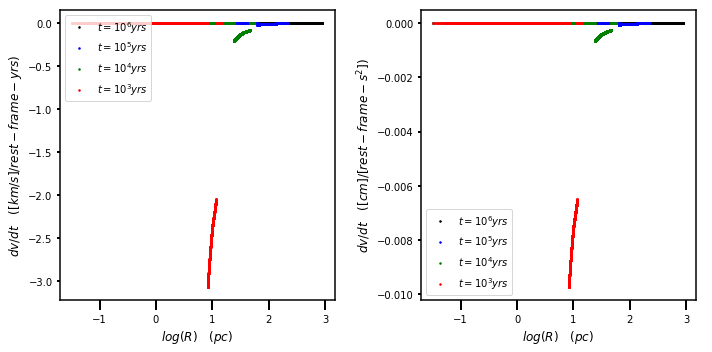

In [73]:
#---Plot dv/dt(R) for time steps
print(min(dv_dt[1]))
dv_dt[1].remove(min(dv_dt[1])); dv_dt[1].append(0)
print(min(dv_dt[1]))

print(min(dv_dt2[1]))
dv_dt2[1].remove(min(dv_dt2[1])); dv_dt2[1].append(0)
print(min(dv_dt2[1]))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(np.log10(r_t1[4]),(dv_dt[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[0].plot(np.log10(r_t1[3]),(dv_dt[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[0].plot(np.log10(r_t1[2]),(dv_dt[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[0].plot(np.log10(r_t1[1]),(dv_dt[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[0].legend(loc='upper left')
axes[0].set_ylabel(r'$dv/dt \quad ([km/s]/rest-frame-yrs)$', fontsize=12)
axes[0].set_xlabel(r'$log(R) \quad (pc)$', fontsize=12)
#---t=10^4yr
axes[1].plot(np.log10(r_t1[4]),(dv_dt2[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[1].plot(np.log10(r_t1[3]),(dv_dt2[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[1].plot(np.log10(r_t1[2]),(dv_dt2[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[1].plot(np.log10(r_t1[1]),(dv_dt2[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[1].legend(loc='lower left')
axes[1].set_ylabel(r'$dv/dt \quad ([cm]/[rest-frame-s^2])$', fontsize=12)
axes[1].set_xlabel(r'$log(R) \quad (pc)$', fontsize=12)

plt.tight_layout()
plt.savefig('Weaver&FGShockBubble_dvdtVSr_ColDen2.png',bbox_inches='tight')
plt.show()

-2225.98103584014
-3.0701292183937765
-7.057644374889474
-0.00973408122509124


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarnin

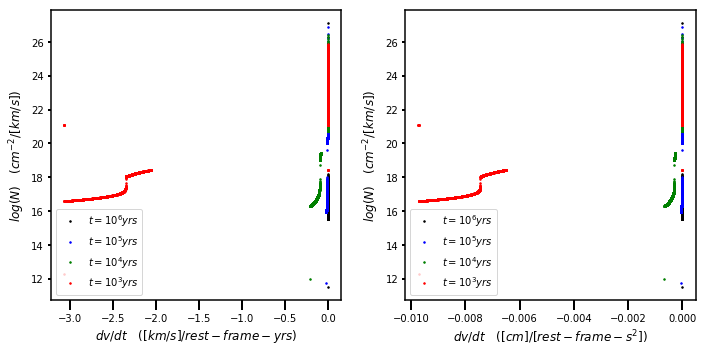

In [64]:
#---Plot N(r) & N(a) for time steps
print(min(dv_dt[1]))
dv_dt[1].remove(min(dv_dt[1])); dv_dt[1].append(0)
print(min(dv_dt[1]))

print(min(dv_dt2[1]))
dv_dt2[1].remove(min(dv_dt2[1])); dv_dt2[1].append(0)
print(min(dv_dt2[1]))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot((dv_dt[4]),np.log10(N_t1[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[0].plot((dv_dt[3]),np.log10(N_t1[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[0].plot((dv_dt[2]),np.log10(N_t1[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[0].plot((dv_dt[1]),np.log10(N_t1[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[0].legend(loc='lower left')
axes[0].set_ylabel(r'$log(N) \quad (cm^{-2}/[km/s])$', fontsize=12)
axes[0].set_xlabel(r'$dv/dt \quad ([km/s]/rest-frame-yrs)$', fontsize=12)
#---t=10^4yr
axes[1].plot((dv_dt2[4]),np.log10(N_t1[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[1].plot((dv_dt2[3]),np.log10(N_t1[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[1].plot((dv_dt2[2]),np.log10(N_t1[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[1].plot((dv_dt2[1]),np.log10(N_t1[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[1].legend(loc='lower left')
axes[1].set_ylabel(r'$log(N) \quad (cm^{-2}/[km/s])$', fontsize=12)
axes[1].set_xlabel(r'$dv/dt \quad ([cm]/[rest-frame-s^2])$', fontsize=12)

plt.tight_layout()
plt.savefig('Weaver&FGShockBubble_logNVSdvdt_ColDen2.png',bbox_inches='tight')
plt.show()

#---Plot log(N) vs R for different timesteps

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5.5))
#---t=10^3yr
axes[0,0].axvline(x=R1_t[0],color='black',linestyle="--")
axes[0,0].axvline(x=Rc_t[0],color='black',linestyle="--")
axes[0,0].axvline(x=R2_t[0],color='black',linestyle="--")
axes[0,0].plot((r_t[1]),np.log10(N_t[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[0,0].set_xlim(0,15)
axes[0,0].set_ylabel(r'$log(N) \quad (cm^{-2}/[km/s])$', fontsize=12)
axes[0,0].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[0,0].legend(loc='upper right')
#---t=10^4yr
axes[0,1].axvline(x=R1_t[1],color='black',linestyle="--")
axes[0,1].axvline(x=Rc_t[1],color='black',linestyle="--")
axes[0,1].axvline(x=R2_t[1],color='black',linestyle="--")
axes[0,1].plot((r_t[2]),np.log10(N_t[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[0,1].set_xlim(0,60)
axes[0,1].set_ylabel(r'$log(N) \quad (cm^{-2}/[km/s])$', fontsize=12)
axes[0,1].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[0,1].legend(loc='upper right')
#---t=10^5yr
axes[1,0].axvline(x=R1_t[2],color='black',linestyle="--")
axes[1,0].axvline(x=Rc_t[2],color='black',linestyle="--")
axes[1,0].axvline(x=R2_t[2],color='black',linestyle="--")
axes[1,0].plot((r_t[3]),np.log10(N_t[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[1,0].set_xlim(0,250)
axes[1,0].set_ylabel(r'$log(N) \quad (cm^{-2}/[km/s])$', fontsize=12)
axes[1,0].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[1,0].legend(loc='upper right')
#---t=10^6yr
axes[1,1].axvline(x=R1_t[3],color='black',linestyle="--")
axes[1,1].axvline(x=Rc_t[3],color='black',linestyle="--")
axes[1,1].axvline(x=R2_t[3],color='black',linestyle="--")
axes[1,1].plot((r_t[4]),np.log10(N_t[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[1,1].set_xlim(0,1000)
axes[1,1].set_ylabel(r'$log(N) \quad (cm^{-2}/[km/s])$', fontsize=12)
axes[1,1].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[1,1].legend(loc='upper right')

plt.tight_layout()
plt.savefig('Weaver&FGShockBubble_logNVSr_ColDen_subplots.png',bbox_inches='tight')
plt.show()

#Plot log(n) vs log(R) plot for different t steps
plt.plot(np.log10(r_t[4]),np.log10(N_t[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
plt.plot(np.log10(r_t[3]),np.log10(N_t[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
plt.plot(np.log10(r_t[2]),np.log10(N_t[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
plt.plot(np.log10(r_t[1]),np.log10(N_t[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
plt.legend(loc='lower left')
plt.ylabel(r'$log(N) \quad (cm^{-2}/[km/s])$', fontsize=12)
plt.xlabel(r'$log(R) \quad (pc)$', fontsize=12)
plt.savefig('Weaver&FGShockBubble_logNVSlogr_ColDen_t10^3-10^6.png',bbox_inches='tight')
plt.show()

#---Plot N(v_gas) for time steps (both linear and log)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5.5))
#---t=10^3yr
axes[0,0].plot((vg_t[1]),np.log10(N_t[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[0,0].set_ylabel(r'$log(N) \quad (cm^{-2}/[km/s])$', fontsize=12)
axes[0,0].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
axes[0,0].legend(loc='upper right',bbox_to_anchor =(0.95,1))
#---t=10^4yr
axes[0,1].plot((vg_t[2]),np.log10(N_t[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[0,1].set_ylabel(r'$log(N) \quad (cm^{-2}/[km/s])$', fontsize=12)
axes[0,1].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
axes[0,1].legend(loc='upper right',bbox_to_anchor =(0.95,1))
#---t=10^5yr
axes[1,0].plot((vg_t[3]),np.log10(N_t[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[1,0].set_ylabel(r'$log(N) \quad (cm^{-2}/[km/s])$', fontsize=12)
axes[1,0].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
axes[1,0].legend(loc='upper right',bbox_to_anchor =(0.95,1))
#---t=10^6yr
axes[1,1].plot((vg_t[4]),np.log10(N_t[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[1,1].set_ylabel(r'$log(N) \quad (cm^{-2}/[km/s])$', fontsize=12)
axes[1,1].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
axes[1,1].legend(loc='upper right',bbox_to_anchor =(0.95,1))

plt.tight_layout()
plt.savefig('Weaver&FGShockBubble_logNVSvgas_ColDen_sublpots.png',bbox_inches='tight')
plt.show()


#Plot log(N) vs (vgas) for different t steps
plt.plot((vg_t[4]),np.log10(N_t[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
plt.plot((vg_t[3]),np.log10(N_t[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
plt.plot((vg_t[2]),np.log10(N_t[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
plt.plot((vg_t[1]),np.log10(N_t[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
plt.legend(loc='upper right', bbox_to_anchor =(0.95,1))
plt.ylabel(r'$log(N) \quad (cm^{-2}/[km/s])$', fontsize=12)
plt.xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)
plt.savefig('Weaver&FGShockBubble_logNVSvgas_ColDen_t10^3-10^6.png',bbox_inches='tight')
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide 

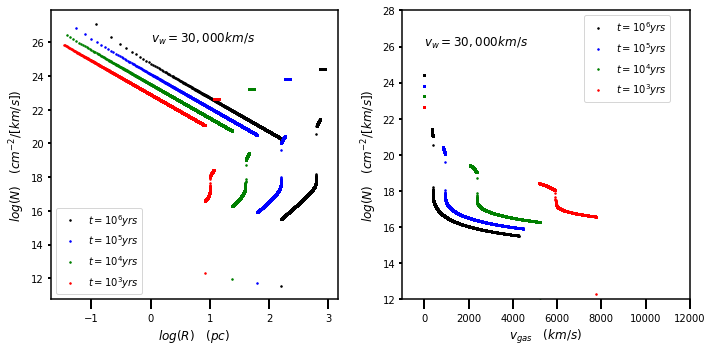

In [24]:
#---Plot N(r) & N(v_gas) for time steps (both linear and log)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
#---t=10^3yr
axes[0].plot(np.log10(r_t[4]),np.log10(N_t[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[0].plot(np.log10(r_t[3]),np.log10(N_t[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[0].plot(np.log10(r_t[2]),np.log10(N_t[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[0].plot(np.log10(r_t[1]),np.log10(N_t[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[0].legend(loc='lower left')
axes[0].text(0.0, 26.0, r'$v_w=30,000km/s$', fontsize=12)
axes[0].set_ylabel(r'$log(N) \quad (cm^{-2}/[km/s])$', fontsize=12)
axes[0].set_xlabel(r'$log(R) \quad (pc)$', fontsize=12)
#---t=10^4yr
axes[1].plot((vg_t[4]),np.log10(N_t[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[1].plot((vg_t[3]),np.log10(N_t[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[1].plot((vg_t[2]),np.log10(N_t[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[1].plot((vg_t[1]),np.log10(N_t[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[1].legend(loc='upper right', bbox_to_anchor =(0.95,1))
axes[1].text(0.0, 26.0, r'$v_w=30,000km/s$', fontsize=12)
axes[1].set_ylim(12,28)
axes[1].set_xlim(-1000,12000)
axes[1].set_ylabel(r'$log(N) \quad (cm^{-2}/[km/s])$', fontsize=12)
axes[1].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)

plt.tight_layout()
plt.savefig('Weaver&FGShockBubble_logNVSr&vgas_ColDen_vw30000.png',bbox_inches='tight')
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide 

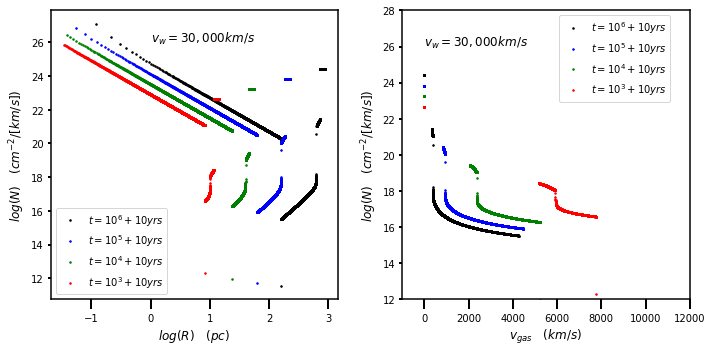

In [26]:
#---Plot N(r) & N(v_gas) for time steps (both linear and log)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
#---t=10^3yr
axes[0].plot(np.log10(r_t[4]),np.log10(N_t[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[0].plot(np.log10(r_t[3]),np.log10(N_t[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[0].plot(np.log10(r_t[2]),np.log10(N_t[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[0].plot(np.log10(r_t[1]),np.log10(N_t[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[0].legend(loc='lower left')
axes[0].text(0.0, 26.0, r'$v_w=30,000km/s$', fontsize=12)
axes[0].set_ylabel(r'$log(N) \quad (cm^{-2}/[km/s])$', fontsize=12)
axes[0].set_xlabel(r'$log(R) \quad (pc)$', fontsize=12)
#---t=10^4yr
axes[1].plot((vg_t[4]),np.log10(N_t[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[1].plot((vg_t[3]),np.log10(N_t[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[1].plot((vg_t[2]),np.log10(N_t[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[1].plot((vg_t[1]),np.log10(N_t[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[1].legend(loc='upper right', bbox_to_anchor =(0.95,1))
axes[1].text(0.0, 26.0, r'$v_w=30,000km/s$', fontsize=12)
axes[1].set_ylim(12,28)
axes[1].set_xlim(-1000,12000)
axes[1].set_ylabel(r'$log(N) \quad (cm^{-2}/[km/s])$', fontsize=12)
axes[1].set_xlabel(r'$v_{gas} \quad (km/s)$', fontsize=12)

plt.tight_layout()
plt.savefig('Weaver&FGShockBubble_logNVSr&vgas_ColDen_vw30000.png',bbox_inches='tight')
plt.show()

In [4]:
dv_cut={}

dv_cut[1]=dv_t[1]; dv_cut[2]=dv_t[2]; dv_cut[3]=dv_t[3]; dv_cut[4]=dv_t[4];

dv_cut[1].remove(min(dv_t[1])); dv_cut[1].append(0)
dv_cut[1].remove(min(dv_t[1])); dv_cut[1].append(0)
dv_cut[2].remove(min(dv_t[2])); dv_cut[2].append(0)
dv_cut[2].remove(min(dv_t[2])); dv_cut[2].append(0)
dv_cut[3].remove(min(dv_t[3])); dv_cut[3].append(0)
dv_cut[3].remove(min(dv_t[3])); dv_cut[3].append(0)
dv_cut[4].remove(min(dv_t[4])); dv_cut[4].append(0)
dv_cut[4].remove(min(dv_t[4])); dv_cut[4].append(0)


In [5]:
#---Plot n(v_gas) for time steps (both linear and log)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5.5))
#---t=10^3yr
axes[0,0].hist(dv_cut[1],color='red',label=r'$t=10^{3} yrs$')
axes[0,0].set_ylabel(r'$#$', fontsize=12)
axes[0,0].set_xlabel(r'$dv_{gas} \quad (km/s)$', fontsize=12)
axes[0,0].legend(loc='upper right',bbox_to_anchor =(0.95,1))
#---t=10^4yr
axes[0,1].hist(dv_cut[2],color='green',label=r'$t=10^{4} yrs$')
axes[0,1].set_ylabel(r'$#$', fontsize=12)
axes[0,1].set_xlabel(r'$dv_{gas} \quad (km/s)$', fontsize=12)
axes[0,1].legend(loc='upper right',bbox_to_anchor =(0.95,1))
#---t=10^5yr
axes[1,0].hist(dv_cut[3],color='blue',label=r'$t=10^{5} yrs$')
axes[1,0].set_ylabel(r'$#$', fontsize=12)
axes[1,0].set_xlabel(r'$dv_{gas} \quad (km/s)$', fontsize=12)
axes[1,0].legend(loc='upper right',bbox_to_anchor =(0.95,1))
#---t=10^6yr
axes[1,1].hist(dv_cut[4],color='black',label=r'$t=10^{6} yrs$')
axes[1,1].set_ylabel(r'$#$', fontsize=12)
axes[1,1].set_xlabel(r'$dv_{gas} \quad (km/s)$', fontsize=12)
axes[1,1].legend(loc='upper right',bbox_to_anchor =(0.95,1))

plt.tight_layout()
plt.savefig('Weaver&FGShockBubble_dv_hist.png',bbox_inches='tight')
plt.show()

ValueError: 
$#$
^
Expected end of text (at char 0), (line:1, col:1)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x10d41ed90> (for post_execute):


ValueError: 
$#$
^
Expected end of text (at char 0), (line:1, col:1)

ValueError: 
$#$
^
Expected end of text (at char 0), (line:1, col:1)

<Figure size 504x396 with 4 Axes>

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5.5))
#---t=10^3yr
axes[0,0].axvline(x=R1_t[0],color='black',linestyle="--")
axes[0,0].axvline(x=Rc_t[0],color='black',linestyle="--")
axes[0,0].axvline(x=R2_t[0],color='black',linestyle="--")
axes[0,0].plot((r_t[1]),(dv_cut[1]),color='red',linestyle="",marker='.',markersize=3,label=r'$t=10^{3} yrs$')
axes[0,0].set_ylabel(r'$dv_{gas} \quad (km/s)$', fontsize=12)
axes[0,0].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[0,0].legend(loc='lower right',bbox_to_anchor =(0.95,1))
#---t=10^4yr
axes[0,1].axvline(x=R1_t[1],color='black',linestyle="--")
axes[0,1].axvline(x=Rc_t[1],color='black',linestyle="--")
axes[0,1].axvline(x=R2_t[1],color='black',linestyle="--")
axes[0,1].plot((r_t[2]),(dv_cut[2]),color='green',linestyle="",marker='.',markersize=3,label=r'$t=10^{4} yrs$')
axes[0,1].set_ylabel(r'$dv_{gas} \quad (km/s)$', fontsize=12)
axes[0,1].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[0,1].legend(loc='lower right',bbox_to_anchor =(0.95,1))
#---t=10^5yr
axes[1,0].axvline(x=R1_t[2],color='black',linestyle="--")
axes[1,0].axvline(x=Rc_t[2],color='black',linestyle="--")
axes[1,0].axvline(x=R2_t[2],color='black',linestyle="--")
axes[1,0].plot((r_t[3]),(dv_cut[3]),color='blue',linestyle="",marker='.',markersize=3,label=r'$t=10^{5} yrs$')
axes[1,0].set_ylabel(r'$dv_{gas} \quad (km/s)$', fontsize=12)
axes[1,0].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[1,0].legend(loc='lower right',bbox_to_anchor =(0.95,1))
#---t=10^6yr
axes[1,1].axvline(x=R1_t[3],color='black',linestyle="--")
axes[1,1].axvline(x=Rc_t[3],color='black',linestyle="--")
axes[1,1].axvline(x=R2_t[3],color='black',linestyle="--")
axes[1,1].plot((r_t[4]),(dv_cut[4]),color='black',linestyle="",marker='.',markersize=3,label=r'$t=10^{6} yrs$')
axes[1,1].set_ylabel(r'$dv_{gas} \quad (km/s)$', fontsize=12)
axes[1,1].set_xlabel(r'$R \quad (pc)$', fontsize=12)
axes[1,1].legend(loc='lower right',bbox_to_anchor =(0.95,1))

plt.tight_layout()
plt.savefig('Weaver&FGShockBubble_logdvgasVSr_ColDen_sublpots.png',bbox_inches='tight')
plt.show()